# Recalculating Accretion Rates:

### 1. Accretion luminosity:
    
*Variables needed:*
        
1. name of emission line
    
2. emission line flux
    
3. object distance

*Procedure:*

1. Turn line flux into line luminosity using distance estimate, or existing line luminosity into an updated one using updated distance estimate

2. Turn line luminosity into accretion luminosity using scaling relations from Alcala (2017).

### 2. Accretion rate:

*Variables needed:*

1. accretion luminosity

2. object mass (from spectral type to temperature to evolutionary tracks)

3. object radius (from evolutionary tracks as well)

4. magnetospheric radius (assumed to be 5 \* object radius)

In [4]:
from numpy import *
import astropy.units as u
from astropy.constants import G, M_jup, R_jup, M_earth, R_earth, L_sun, M_sun, R_sun
import pandas as pd

In [2]:
#import scaling relation coefficients
rel = pd.read_csv('scaling_relations_alcala2017_copy.csv')
rel.set_index('Tracer', inplace=True)

In [3]:
#line luminosity functions

def line_lum_distconv(line_lum_old, dist_old, dist_new):
    """
    Calculate the line luminosity at a distance
    given the line luminosity at another distance.
    
    """
    line_lum_new = line_lum_old * (dist_old**2)/(dist_new**2)
    return line_lum_new

def line_lum(line_flux, dist):
    """
    Calculate line luminosity given line flux and distance
    assuming line flux is extinction corrected.
    """
    #future: could add extinction correction in there? Not sure how that works.
    
    line_lum = 4 * pi * dist**2 * line_flux
    return line_lum

In [40]:
def accr_lum(L_line, tracer, L_line_err = 0*u.W):
    """
    Translate a line luminosity to accretion luminosity using empirical
    relationships from Alcala et al. 2017.
    
    Included tracers are:
    'H_alpha'
    'H_beta'
    'H_gamma'
    'H_delta'
    'H_epsilon'
    'Pa_beta'
    'Pa_gamma'
    'He_I_587.6'
    'He_I_667.8'
    'Ca_II_K'
    'Ca_II_H'
    'Ca_II_866.2'
    """
        
    a, a_err, b, b_err = rel['a'][tracer],rel['a_err'][tracer],rel['b'][tracer],rel['b_err'][tracer]
    
    log_L_acc = b + a * log10(L_line*u.W/L_sun)
    
    L_acc = 10**log_L_acc*L_sun
    
    #attempt at error propagation
    
    #c_err = (L_line_err)/(log(10) * L_line)
    #ac_err = a * log10(L_line/L_sun) * ((a_err/a)**2 + (c_err/log10(L_line/L_sun))**2)**0.5
    #log_L_acc_err = (b_err**2 + ac_err**2)**0.5
    #L_acc_err = L_acc * log(10) * log_L_acc_err

    return L_acc

In [1]:
def L_acc_list(L_line_list, tracer):
    laccl = [accr_lum(i,t) for i in L_line_list]
    return laccl

***Error propagation:*** *this is how I **think** the error propagation should work for the scaling relation. Need to check this.*

Overall formula: $\log (L_{acc}/L_{\odot}) = a \cdot \log(L_{line}/L_{\odot}) + b$

Errors:

$\delta c = \delta \log(L_{line}/L_{\odot}) = \frac{1}{\ln10} \frac{\delta L_{line}}{L_{line}}$

$\delta ac = ac \cdot \sqrt{(\frac{\delta a}{a})^2 + (\frac{\delta c}{c})^2}$

$\delta \log(L_{acc}) = \delta (ac + b)= \sqrt{(\delta ac)^2 + (\delta b)^2}$

In [43]:
def acc_rate(L_acc, R, M):
    """
    Translate an accretion luminosity and planet mass/radius to accretion rate in Solar masses per year.
    """
    mdot = 1.25*L_acc*R*u.R_sun/(G*M*u.M_sun)
    mdot = mdot.decompose().to(u.M_sun/u.yr)
    return(mdot)

### Cells above: functions for conversions and calculations

### Cells below: tests with the database

***Goal of 7/4:***

1. write out in words the exact process needed to convert the database's line fluxes into line luminosities, line luminosities to accretion luminosities, then l_acc to mdot for each tracer in the database. note that i will need to have a lot of data columns, many of which will be mostly NaN. Making a new column for every tracer was easier than making a new row, but it means it'll be harder to plot. I guess I can iterate over list of lists and plot M vs Mdot[0], M vs Mdot[1], etc.

2. draft the code that can do that. note that I cannot actually run it without distance estimate for the points. Could create a fake distance column of all 100 pc, for example.

***1. Import database. Keep only relevant columns, which are:***

**Source, Mass, Radius, Distance, Line Flux (each tracer)**

*Additional considerations:*

1. Do I want to import age and disk type etc, too? Probably, as we will want to use them to narrow down the physical causes of scatter in the relation.

2. Do I want a flag for line flux from EW? Not sure.

3. Do I want to have empty columns for L_line for each tracer? Or create them as I go?

4. It really would be easier to do this if I had a row for each instance of each source, rather than columns for each tracer. Then I could simply take acc_lum(db['tracer'][i], db['Line Lum'][i]) once for each row. Is there a way I can easily make the database into that style now? I don't think so.

***2. Convert every line flux to a line luminosity***

    for i in range(len(db)):

        #do i need to specify that the line_flux value is not NaN? If so, above each line here, add if isnan(db['tracerj line flux'][i])==False
        
        db.at[i,'tracer1 line lum'] = line_lum(db['tracer1 line flux'][i], db['distance'][i]
        db.at[i,'tracer2 line lum'] = line_lum(db['tracer2 line flux'][i], db['distance'][i]
        ...    
        db.at[i,'tracern line lum'] = line_lum(db['tracern line flux'][i], db['distance'][i]


Alternatively, get a list of tracers: ['t1','t2','t3',...,'tn']
Then:

    for i in range(len(db)):
        for t in tracers:
            if isnan(db[t + 'line flux'][i]) == False:
                db.at[i,t + 'line lum'] = line_lum(db[t + 'line flux'][i], db['distance'][i]
        
Yeah this solution is better. If it works :)

***3. Convert every line luminosity to an accretion luminosity***

    for i in range(len(db)):
        for t in tracers:
            db.at[i,t + 'acc lum'] = acc_lum(db[t + 'line lum'][i], t)

***4. Convert every accretion luminosity into an accretion rate***

Follow similar procedure as above. Do I want to average them yet? I think not. We could do a plot of averaged for each source and not averaged.

    for i in range(len(db)):
        for t in tracers:
            db.at[i,t + 'acc rate'] = acc_rate(db[t + 'acc lum'][i], db['radius'][i], db['mass'][i])
        
**Additional considerations:**

This procedure does *not* account for 1. The papers that only report EW. 2. The papers that report L but not flux. 3. The other ones that do none of these things. Can do these by:

1. Getting flux *from* EW using either R band magnitude or a complex spectral type fitting method.

2. Turning L_line into new L_line using distance conversion. To do so, need the old distance estimate (ex Natta 2006 only reports L(Pa$\beta$).

3. ???

This is the basic procedure, though.

***5. Plotting***



In [5]:
db = pd.read_csv('accdb_master_copy.csv')

Example/test: Natta 2006

Given Pa$\beta$ luminosity, convert to accretion luminosity

In [14]:
natta06 = db[db['Reference']=='Natta 2006']
n06 = natta06[['Source', 'Object Mass M_Solar','Object Radius from L and T','PaB Line Lum (L_solar)','Log Accretion Luminosity (solar)']]
n06 = n06.dropna()

In [17]:
n06['accr rate'] = zeros(len(n06))

In [41]:
l_line = [float(i) for i in n06['PaB Line Lum (L_solar)'].tolist()]
log_l_acc_orig = [float(i) for i in n06['Log Accretion Luminosity (solar)'].tolist()]
l_acc = L_acc_list(l_line,'Pa_beta')

In [44]:
m = [float(i) for i in n06['Object Mass M_Solar'].tolist()]
r = [float(i) for i in n06['Object Radius from L and T'].tolist()]
acc = [acc_rate(l_acc[i],r[i],m[i]) for i in range(len(l_acc))]

In [11]:
import matplotlib.pyplot as plt

In [12]:
polyfit(log_l_acc_orig, log_l_acc,1)

array([ 0.77918867, -0.35909077])

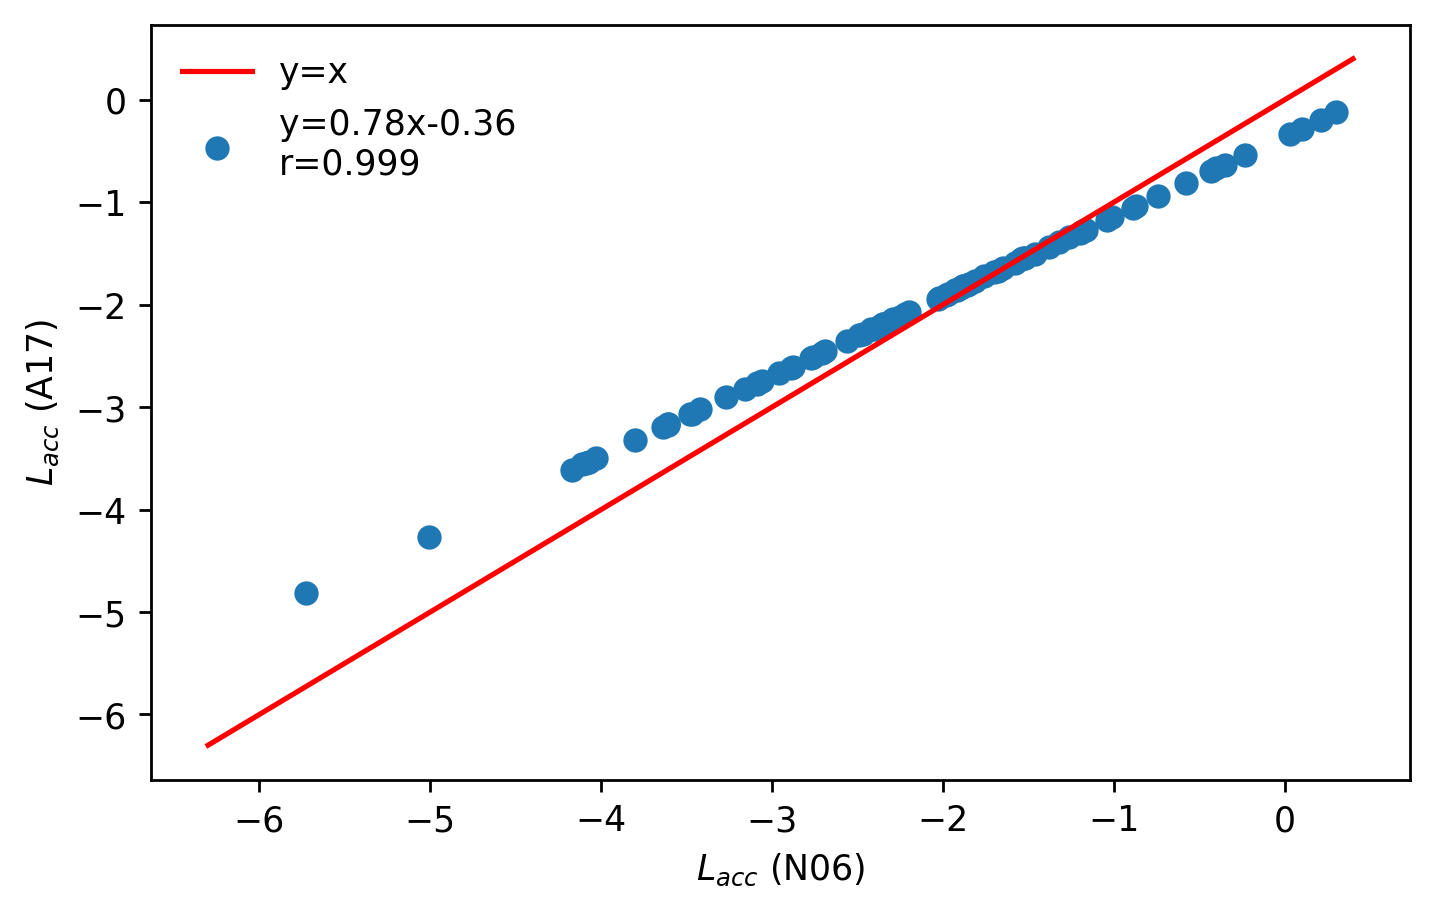

In [25]:
plt.figure(figsize = (6.5,4), dpi = 250)
plt.scatter(log_l_acc_orig, log_l_acc,label='y=0.78x-0.36 \nr=0.999')
labx = plt.xlabel('$L_{acc}$ (N06)')
laby = plt.ylabel('$L_{acc}$ (A17)')
x = arange(-6.3,0.5,.1)
plt.plot(x,x, color = 'r',label = 'y=x')
plt.legend(frameon=False)